In [27]:
# Importing dependancies

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [28]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [29]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [30]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [31]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [32]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [33]:
# Creating SQLAlchemy inspector which will allow inspection of tables in DB
inspector = inspect(engine)

In [34]:
# Get the list of column names and data type in table 'measurement'
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [35]:
# Get the list of column names and data type in table 'measurement'
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [36]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [37]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)
# print(str(recent_date))
# latest_date = dt.datetime.strptime(str(recent_date), '%y-%m-%d').date()
# print(latest_date)

('2017-08-23',)


In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.

one_year = dt.date(2017,8,23)- dt.timedelta(days=365)
print(one_year)


# Perform a query to retrieve the data and precipitation scores

sel = [Measurement.date,func.sum(Measurement.prcp)]

precipitation = session.query(*sel).\
                filter(func.strftime(Measurement.date >= one_year)).\
                group_by(Measurement.date).\
                order_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation, columns=['Date','Precipitation'])
precipitation_df.set_index('Date', inplace=True)

# Removing rows with NA value
precipitation_df.dropna(axis=0, how='any', inplace=True)

# Sort the dataframe by date
precipitation_df.sort_values(by='Date')
precipitation_df.head()

2016-08-23


,Precipitation
Date,
2016-08-23,68.9
2016-08-24,236.9
2016-08-25,13.6
2016-08-26,2.6
2016-08-27,8.1


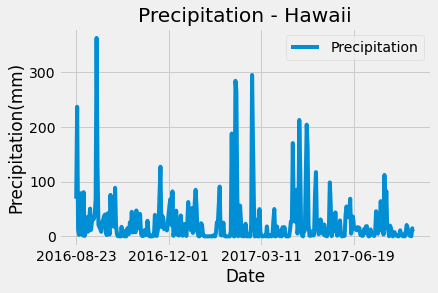

In [39]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot()
plt.tight_layout()
plt.xlabel('Date')
plt.ylabel('Precipitation(mm)')
plt.title('Precipitation - Hawaii')
plt.show()

In [40]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = precipitation_df.describe()
summary_stats

,Precipitation
count,366.000000
mean,24.880874
std,45.110917
min,0.000000
25%,1.425000
50%,10.250000
75%,27.650000
max,362.700000


In [41]:
stations=session.query(Station.station)
stations

# Exploratory Station Analysis

In [42]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.station).group_by(Station.station).count()

9

In [43]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.date)]

active_stations = session.query(*sel).group_by(Measurement.station).\
                    order_by(func.count(Measurement.date).desc()).all()

print(active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [44]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,
      func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]

active_station_temp_summary = session.query(*sel).\
                            filter(Measurement.station == 'USC00519281').all()

print(active_station_temp_summary)

[('USC00519281', 12.2, 29.4, 22.03582251082252)]


In [45]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date, Measurement.tobs]

active_station_temp = session.query(*sel).\
                    filter(func.strftime(Measurement.date) >= one_year, Measurement.station == 'USC00519281').\
                    group_by(Measurement.date).\
                    order_by(Measurement.date).all()
active_station_df = pd.DataFrame(active_station_temp, columns = ['Date','Temprature'])
active_station_df.head()



,Date,Temprature
0,2016-08-23,25.0
1,2016-08-24,25.0
2,2016-08-25,26.7
3,2016-08-26,26.7
4,2016-08-27,23.9


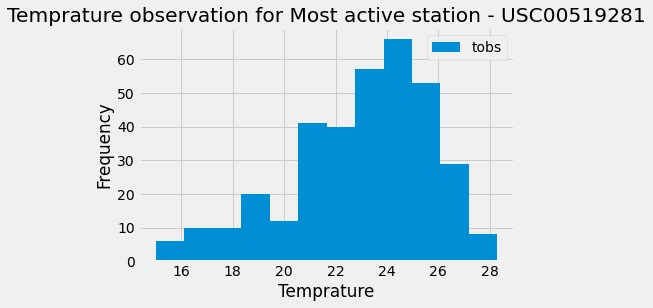

In [46]:
plt.hist(active_station_df['Temprature'],bins=12, density=False, label='tobs')
plt.xlabel('Temprature')
plt.ylabel('Frequency')
plt.legend()
plt.title('Temprature observation for Most active station - USC00519281')
plt.figsize=(10,6)
plt.show()

# Close session

In [47]:
# Close Session
session.close()